# Import modules

In [4]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pacmap

from itertools import permutations,product
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [ ]:
# %load_ext autoreload
# %%autoreload 2

In [6]:
plt.rcParams['figure.figsize'] = (16,10)

In [7]:
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis

## General info

In [8]:
df = pd.read_csv('int20h-ds-test-dataset.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23357 entries, 0 to 23356
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   userid              23357 non-null  object
 1   user_state          23286 non-null  object
 2   event_name          23357 non-null  object
 3   event_attributes    23357 non-null  object
 4   event_created_date  23357 non-null  object
 5   event_platform      23357 non-null  object
 6   device_manufacture  15847 non-null  object
 7   device_model        15847 non-null  object
dtypes: object(8)
memory usage: 1.4+ MB


In [10]:
df.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


## Unique analysis 

In [11]:
df[['userid', 'user_state', 'event_platform','device_manufacture', 'device_model']].nunique()

userid                3540
user_state              49
event_platform           3
device_manufacture      22
device_model           290
dtype: int64

In [12]:
df['event_platform'].unique()

array(['android', 'ios', 'outofband'], dtype=object)

In [13]:
df['event_name'].unique()

array(['Add Vehicle Success', 'Add Vehicle Break', 'Calculator View',
       'Add Payment Method Success', 'Sign Up Success',
       'Add Payment Method Failed', 'Wallet Opened', 'Transaction Refund',
       'Email Confirmation Success', 'Account Setup Skip',
       'Subscription Premium', 'Chat Conversation Opened',
       'Account Setup Profile Skip',
       'Account History Transaction Details', 'Sign Out',
       'Chat Conversation Started', 'Order', 'Sign Up Error',
       'Subscription Premium Cancel', 'Calculator Used',
       'Subscription Premium Renew', 'Add Vehicle Failed',
       'Reset Password Set'], dtype=object)

## Feature Exploration
### to datetime and categorical and normalizing JSON fields

In [14]:
df['event_created_date'] = pd.to_datetime(df['event_created_date'])
df['event_attributes'] = df['event_attributes'].apply(eval)
df_event_attributes = json_normalize(df['event_attributes'])

In [15]:
df_event_attributes.columns

Index(['Make', 'Model', 'Color', 'Year', 'Temporary', 'Start Date', 'End Date',
       'Rental state', 'Payment Method', 'Tokenized Pay', 'Method',
       'Rental State', 'Error Code', 'Error Message', 'Id', 'Amount',
       'Required', 'Renewal Date', 'Membership Type', 'From', 'Screen', 'Type',
       'Navigated From', 'Status', 'Transaction type', 'Premium Membership',
       'Description', 'Google Map Installed', 'Selected Route Type',
       'Transaction Type', 'Promo code'],
      dtype='object')

In [16]:
df_event_attributes['_id'] = range(1,len(df_event_attributes)+1) # adding _id serial column to the events
df_event_attributes['event_created_date'] = df['event_created_date'] # 

### Histogram represents every event rate per users


<AxesSubplot:title={'center':'event rate per unique users'}, xlabel='event_name'>

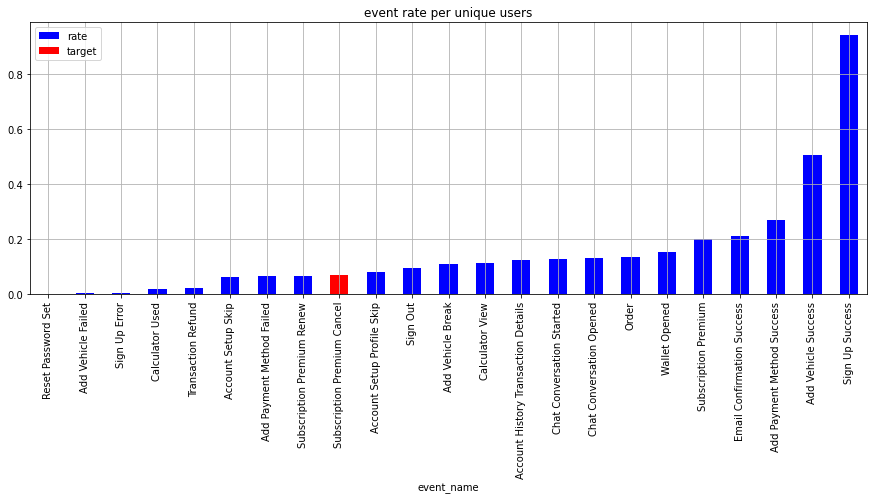

In [17]:
# Histogram represents every event rate per users
user_event_df = df.groupby(['userid', 'event_name'], as_index=False).count()[['userid', 'event_name', 'event_created_date']]
event_df = user_event_df.groupby('event_name', as_index=False).count().sort_values('userid')
n_users = user_event_df.groupby('userid').count().shape[0]

event_df['rate'] = event_df['userid'] / n_users
event_df['target_mask'] = event_df['event_name'] == 'Subscription Premium Cancel'
event_df['target'] = 0
event_df.loc[event_df['target_mask'], 'target'] = event_df.loc[event_df['target_mask'],'rate']
event_df.sort_values('rate', inplace=True)
event_df.loc[event_df['target_mask'], 'rate'] = 0
event_df[['event_name', 'rate', 'target']].plot.bar(x='event_name', figsize=(15, 5), \
    grid=True, title='event rate per unique users', stacked=True,color=['b', 'r'])


In [18]:
user_dicts = []

for userid, subdf in df.groupby('userid', as_index=False):
    df.sort_values('event_created_date', inplace=True)
    result = {'userid': userid}
    result['sub'] = 'Subscription Premium' in subdf['event_name'].to_list()
    if result['sub']:
        result['sub_time'] = subdf[subdf['event_name']=='Subscription Premium'].iloc[0]['event_created_date']
        result['cancel'] = 'Subscription Premium Cancel' in subdf['event_name'].to_list()
        if result['cancel']:
            result['cancel_time'] = subdf[subdf['event_name']=='Subscription Premium Cancel'].iloc[0]['event_created_date']
            s_df = subdf[(subdf['event_created_date']>=result['sub_time']) & 
                       (subdf['event_created_date']<result['cancel_time'])]
            
            for i in range(min([s_df.shape[0], 5])):
                result[f'event_{i+1}_ago'] = s_df.iloc[-1-i]['event_name'] 
                result[f'time_{i+1}_ago'] = s_df.iloc[-1-i]['event_created_date'] 

    
        user_dicts.append(result)
        
user_df = pd.DataFrame(user_dicts)
user_df.head(5)

,userid,sub,sub_time,cancel,cancel_time,event_1_ago,time_1_ago,event_2_ago,time_2_ago,event_3_ago,time_3_ago,event_4_ago,time_4_ago,event_5_ago,time_5_ago
0,0006869712ec9841dc36234bce245203,True,2022-01-19 18:48:01,False,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
1,00596aa4edee32815aaf4aad659c484e,True,2022-02-16 19:38:52,False,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
2,007b54670d72df309afd87befcbb63db,True,2022-04-05 22:00:10,False,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
3,0136a8eeca5d16ac1a521dd0e27ecec0,True,2022-01-18 23:56:30,False,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
4,01529f53aaba5b512168d432d5650556,True,2022-04-09 21:51:10,False,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT


In [21]:
def event_hist_ago(df: pd.DataFrame, i: int):
    event_df = df.groupby(f'event_{i}_ago').count()
    n_users = df.groupby('userid').count().shape[0]
    event_df['userid'] = event_df['userid']
    
event_hist_ago(user_df[user_df['cancel']], 2)

In [22]:
df['cancel'] = (df['event_name']=='Subscription Premium Cancel').astype(int)
print(df['cancel'].describe())

count    23357.000000
mean         0.011603
std          0.107091
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: cancel, dtype: float64


create foreign key

In [23]:
df['event_id'] = df_event_attributes['_id']
df_event_attributes['event_name'] = df['event_name']

In [25]:
df = df.drop(['event_name','event_created_date'],axis=1)
df_event_attributes = df_event_attributes.rename(columns={'_id':'event_id'})
df_event_attributes = df_event_attributes.set_index('event_id')
df_all = df_event_attributes.join(df.set_index('event_id'))
df_all = df_all.drop('event_attributes',axis=1)
df_all[df_all['event_name']=='Subscription Premium'].shape

(711, 39)

<b> Create percentage of events to still active

In [26]:
user_ids_cancelled = df_all[df_all['event_name']=='Subscription Premium Cancel']\
    .groupby('userid').count().reset_index()['userid'].tolist()
user_ids_subscribed = df_all[df_all['event_name']=='Subscription Premium']\
    .groupby('userid').count().reset_index()['userid'].tolist()

In [27]:
len(set(user_ids_cancelled)-set(user_ids_subscribed))

28

<b>Cancellation of subscription by states

In [28]:
percentage_of_cancellation_by_state = df_all[df_all['event_name']=='Subscription Premium Cancel']\
    .groupby('user_state',as_index=False)['event_name']\
    .agg('count')\
    .sort_values('user_state')\
    .set_index('user_state')/df_all[df_all['event_name']=='Subscription Premium']\
    .groupby('user_state',as_index=False)['event_name']\
    .agg('count')\
    .sort_values('user_state')\
    .set_index('user_state')
percentage_of_cancellation_by_state = percentage_of_cancellation_by_state.rename({'event_name':'percentage'},axis=1)
percentage_of_cancellation_by_state = percentage_of_cancellation_by_state\
    .join(df_all[df_all['event_name']=='Subscription Premium Cancel']\
    .groupby('user_state',as_index=False)['event_name']\
    .agg('count')\
    .sort_values('user_state') 
    .set_index('user_state'))
percentage_of_cancellation_by_state = percentage_of_cancellation_by_state.rename({'event_name':'cancelled'},axis=1)
percentage_of_cancellation_by_state = percentage_of_cancellation_by_state\
    .join(df_all[df_all['event_name']=='Subscription Premium']\
    .groupby('user_state',as_index=False)['event_name']\
    .agg('count')\
    .sort_values('user_state')\
    .set_index('user_state'))
percentage_of_cancellation_by_state = percentage_of_cancellation_by_state\
    .rename({'event_name':'subscription'},axis=1)
percentage_of_cancellation_by_state.sort_values(by='percentage',ascending=False).style.background_gradient(axis=0)

,percentage,cancelled,subscription
user_state,,,
AL,1.000000,1.000000,1
GA,1.000000,1.000000,1
UT,1.000000,1.000000,1
TN,1.000000,1.000000,1
AR,1.000000,2.000000,2
IA,1.000000,1.000000,1
WV,1.000000,1.000000,1
DE,1.000000,1.000000,1
DC,1.000000,1.000000,1


In [29]:
df_all['event_name'].unique()

array(['Add Vehicle Success', 'Add Vehicle Break', 'Calculator View',
       'Add Payment Method Success', 'Sign Up Success',
       'Add Payment Method Failed', 'Wallet Opened', 'Transaction Refund',
       'Email Confirmation Success', 'Account Setup Skip',
       'Subscription Premium', 'Chat Conversation Opened',
       'Account Setup Profile Skip',
       'Account History Transaction Details', 'Sign Out',
       'Chat Conversation Started', 'Order', 'Sign Up Error',
       'Subscription Premium Cancel', 'Calculator Used',
       'Subscription Premium Renew', 'Add Vehicle Failed',
       'Reset Password Set'], dtype=object)

In [30]:
len(df_all['event_name'].unique())

23

# Visual Analysis

Here we will get the event history for each user separately. The event history is then split into the time intervals of 5/7/10 days. For each time interval we create a vector representation of the events by calculating their occurences (i.e. $i$-th element of the vector is a total number of occurences of the $i$-th event type in the interval). Interval is labeled as 'target' if it contains 'Subscription Premium Cancel' event or 'regular' otherwise.

These intervals are used to compare the means of events occurences for 'target' and 'regular' intervals. We also train a random forest to obtain feature importances and evaluate its ability to predict subscription cancelation.

In [32]:
df_all['target'] = (df_all['event_name']=='Subscription Premium Cancel').astype(int)


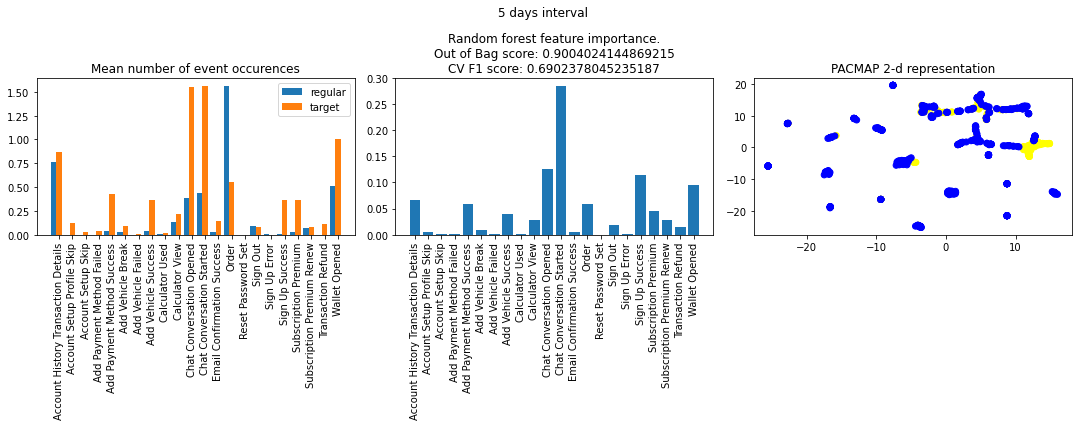

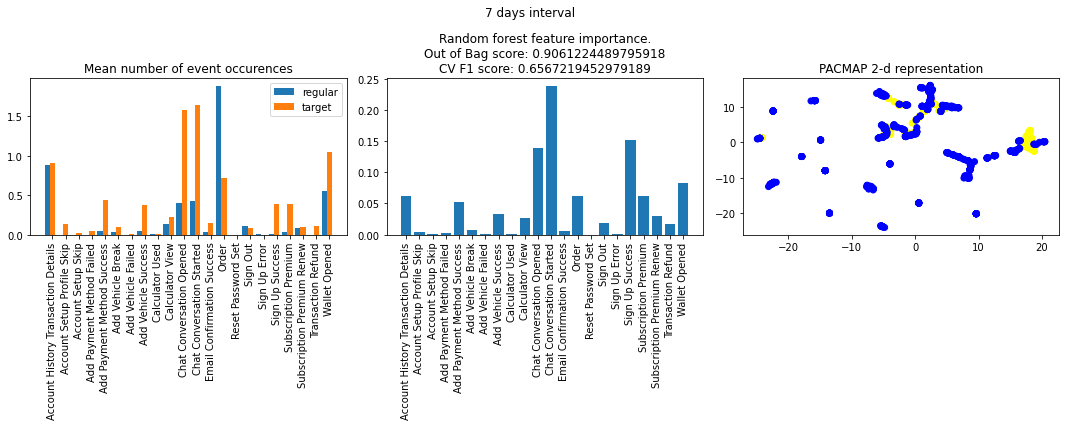

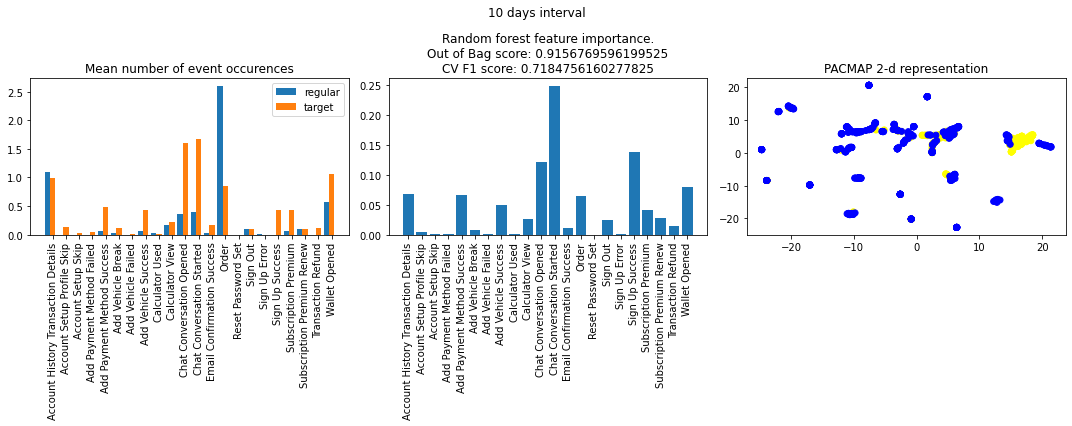

In [33]:
def get_vectors_by_time_interval(df, days):
    users = np.unique(df[df['target'] == 1]['userid'])
    mapping = dict(zip(sorted(event_names), np.arange(n_event_names)))
    
    target_event_vectors = []
    regular_event_vectors = []
    
    for user in users:
        user_events = df_all[df_all['userid'] == user]

        first_date = user_events['event_created_date'].iloc[0]
        cancelation_date = user_events[user_events['target'] == 1]['event_created_date'].values[0]
        start_date = cancelation_date - pd.Timedelta(days, 'd')

        interval_mask = (user_events['event_created_date'] >= start_date) & (user_events['event_created_date'] <= cancelation_date)
        user_events_interval = user_events[interval_mask]
        target_event_vector = np.zeros(n_event_names)
        for event in user_events_interval['event_name'].values:
            if event != 'Subscription Premium Cancel':
                target_event_vector[mapping[event]] += 1
        target_event_vectors.append(target_event_vector)

        end_date = start_date
        start_date = end_date - pd.Timedelta(days, 'd')
        while start_date >= first_date:
            interval_mask = (user_events['event_created_date'] >= start_date) & (user_events['event_created_date'] < end_date)
            user_events_interval = user_events[interval_mask]
            regular_event_vector = np.zeros(n_event_names)
            for event in user_events_interval['event_name'].values:
                if event != 'Subscription Premium Cancel':
                    regular_event_vector[mapping[event]] += 1
            regular_event_vectors.append(regular_event_vector)

            start_date = start_date - pd.Timedelta(1, 'd') 
            end_date = end_date - pd.Timedelta(1, 'd')

    regular_event_vectors = [v for v in regular_event_vectors if sum(v)]
    
    return regular_event_vectors, target_event_vectors



event_names = ['Account History Transaction Details', 'Account Setup Profile Skip', 'Account Setup Skip', 
               'Add Payment Method Failed', 'Add Payment Method Success',  'Add Vehicle Break', 'Add Vehicle Failed',
               'Add Vehicle Success', 'Calculator Used', 'Calculator View', 'Chat Conversation Opened',
               'Chat Conversation Started', 'Email Confirmation Success', 'Order', 'Reset Password Set', 'Sign Out',
               'Sign Up Error', 'Sign Up Success', 'Subscription Premium', 'Subscription Premium Renew',
               'Transaction Refund','Wallet Opened']
n_event_names = len(event_names)

for i, days in enumerate((5, 7, 10)):
    regular_event_vectors, target_event_vectors = get_vectors_by_time_interval(df_all, days)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    regular_event_vectors_mean = np.array(regular_event_vectors).mean(axis=0)
    target_event_vectors_mean = np.array(target_event_vectors).mean(axis=0)
    axes[0].bar(np.arange(len(event_names)) - 0.2, regular_event_vectors_mean, tick_label=event_names, width=0.4, label='regular')
    axes[0].bar(np.arange(len(event_names)) + 0.2, target_event_vectors_mean, tick_label=event_names, width=0.4, label='target')
    axes[0].legend()
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
    axes[0].set_title('Mean number of event occurences')

    combined = np.array(target_event_vectors + regular_event_vectors)
    labels = np.concatenate((np.ones(len(target_event_vectors)), np.zeros(len(regular_event_vectors))))
    forest = RandomForestClassifier(oob_score=True)
    forest.fit(combined, labels)
    cv_score = np.mean(cross_val_score(forest, combined, labels, cv=5, scoring='f1'))
    axes[1].bar(np.arange(len(event_names)), forest.feature_importances_, tick_label=event_names)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    axes[1].set_title(f'Random forest feature importance.\nOut of Bag score: {forest.oob_score_}\nCV F1 score: {cv_score}')

    scaler = StandardScaler()
    combined_s = scaler.fit_transform(combined)
    colors = ['yellow' if i else 'blue' for i in labels]
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
    transformed_pacmap = embedding.fit_transform(combined_s, init="pca")
    axes[2].scatter(transformed_pacmap[:, 0], transformed_pacmap[:, 1], c=colors)
    axes[2].set_title('PACMAP 2-d representation')
    
    plt.suptitle(f'{days} days interval')
    plt.tight_layout()
    plt.show()

We can see that the number of 'Chat Conversation Opened' and 'Chat Conversation Started' significantly increases before subscription cancelation. The number of orders is 2-2.5 times lower before the cancelation than on a regular basis. Random forest attains 0.72 cross val F1-score. Some portion of the vectors is distinguishable in the 2-d pacmap representation.

Repeat the procedure, but split the history into the n-events intervals (20, 25, 30 events in this case).

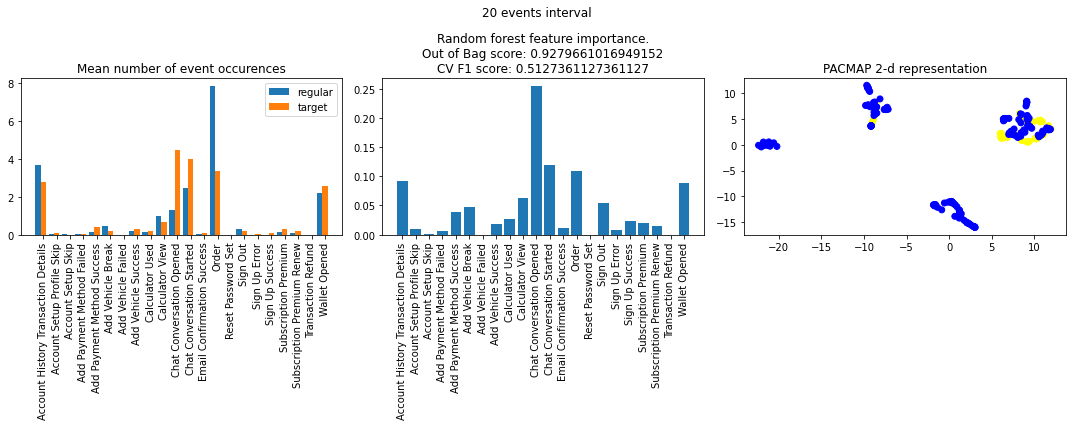

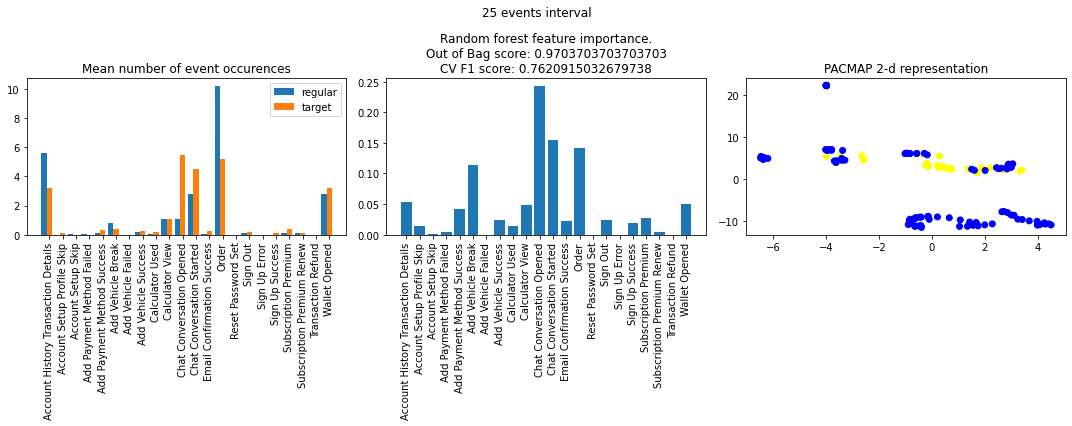

In [ ]:
def get_vectors_by_number_of_events(df, n):
    users = np.unique(df[df['target'] == 1]['userid'])
    
    target_event_vectors = []
    regular_event_vectors = []

    for user in users:
        user_events = df_all[df_all['userid'] == user]
        n_user_events = len(user_events)
        if n_user_events < n:
            continue

        t = user_events
        cancelation_ind = np.where(user_events['target'] == 1)[0][0]
        start_ind = cancelation_ind - n

        if start_ind < 0:
            continue

        user_events_interval = user_events.iloc[start_ind:cancelation_ind]
        target_event_vector = np.zeros(n_event_names)
        for event in user_events_interval['event_name'].values:
            if event != 'Subscription Premium Cancel':
                target_event_vector[mapping[event]] += 1
        target_event_vectors.append(target_event_vector)

        end_ind = start_ind - 1
        start_ind = end_ind - n
        while start_ind > 0:
            user_events_interval = user_events.iloc[start_ind:end_ind]
            regular_event_vector = np.zeros(n_event_names)
            for event in user_events_interval['event_name'].values:
                if event != 'Subscription Premium Cancel':
                    regular_event_vector[mapping[event]] += 1
            regular_event_vectors.append(regular_event_vector)

            start_ind = start_ind - 1
            end_ind = end_ind - 1

    return regular_event_vectors, target_event_vectors


event_names = ['Account History Transaction Details', 'Account Setup Profile Skip', 'Account Setup Skip', 
               'Add Payment Method Failed', 'Add Payment Method Success',  'Add Vehicle Break', 'Add Vehicle Failed',
               'Add Vehicle Success', 'Calculator Used', 'Calculator View', 'Chat Conversation Opened',
               'Chat Conversation Started', 'Email Confirmation Success', 'Order', 'Reset Password Set', 'Sign Out',
               'Sign Up Error', 'Sign Up Success', 'Subscription Premium', 'Subscription Premium Renew',
               'Transaction Refund','Wallet Opened']

n_event_names = len(event_names)
mapping = dict(zip(sorted(event_names), np.arange(n_event_names)))

for i, n in enumerate((20, 25, 30)):
    regular_event_vectors, target_event_vectors = get_vectors_by_number_of_events(df_all, n)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    regular_event_vectors_mean = np.array(regular_event_vectors).mean(axis=0)
    target_event_vectors_mean = np.array(target_event_vectors).mean(axis=0)
    axes[0].bar(np.arange(len(event_names)) - 0.2, regular_event_vectors_mean, tick_label=event_names, width=0.4, label='regular')
    axes[0].bar(np.arange(len(event_names)) + 0.2, target_event_vectors_mean, tick_label=event_names, width=0.4, label='target')
    axes[0].legend()
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
    axes[0].set_title('Mean number of event occurences')

    combined = np.array(target_event_vectors + regular_event_vectors)
    labels = np.concatenate((np.ones(len(target_event_vectors)), np.zeros(len(regular_event_vectors))))
    forest = RandomForestClassifier(oob_score=True)
    forest.fit(combined, labels)
    cv_score = np.mean(cross_val_score(forest, combined, labels, cv=5, scoring='f1'))
    axes[1].bar(np.arange(len(event_names)), forest.feature_importances_, tick_label=event_names)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    axes[1].set_title(f'Random forest feature importance.\nOut of Bag score: {forest.oob_score_}\nCV F1 score: {cv_score}')

    scaler = StandardScaler()
    combined_s = scaler.fit_transform(combined)
    colors = ['yellow' if i else 'blue' for i in labels]
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
    transformed_pacmap = embedding.fit_transform(combined_s, init="pca")
    axes[2].scatter(transformed_pacmap[:, 0], transformed_pacmap[:, 1], c=colors)
    axes[2].set_title('PACMAP 2-d representation')
    
    plt.suptitle(f'{n} events interval')
    plt.tight_layout()
    plt.show()

In [28]:
categorical_columns = ['Color','Error Code','Id','Membership Type','Method','Model', 'Payment Method',
                      'Rental State', 'Rental state','Selected Route Type','Status','Tokenized Pay','Transaction Type',
                      'Transaction type','Type','event_name','userid','user_state','event_platform','device_manufacture',
                       'device_model','Screen','From','Make']
boolean_columns = ['Premium Membership', 'Google Map Installed','Required']
date_columns = ['Start Date','End Date', 'event_created_date']

In [29]:
df_all['Year']=df_all['Year'].astype(float)

In [30]:
for column in categorical_columns:
    df_all[column] = df_all[column].astype('category')
for column in date_columns:
    df_all[column] = pd.to_datetime(df_all[column])

In [31]:
df['device_manufacture'][df['device_manufacture'].isna()]='Missing'

In [ ]:
<b> Let us find user 

<AxesSubplot:ylabel='event_id'>

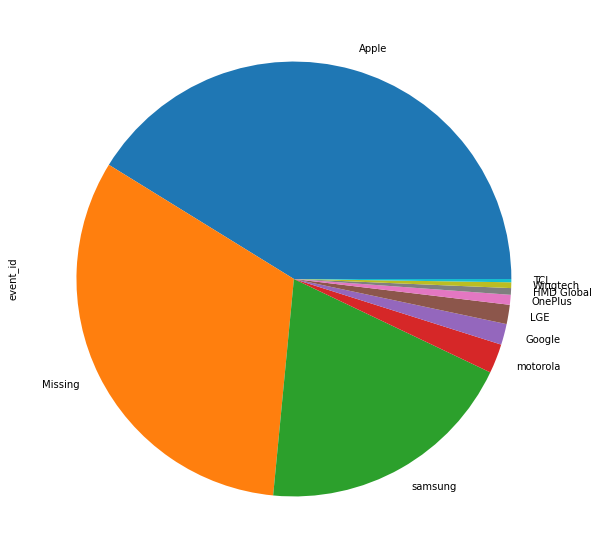

In [139]:
device_manufacture_counter = df.groupby('device_manufacture').count()['event_id'].sort_values(ascending=False)
device_manufacture_counter[device_manufacture_counter>20].plot(kind='pie')

<AxesSubplot:ylabel='userid'>

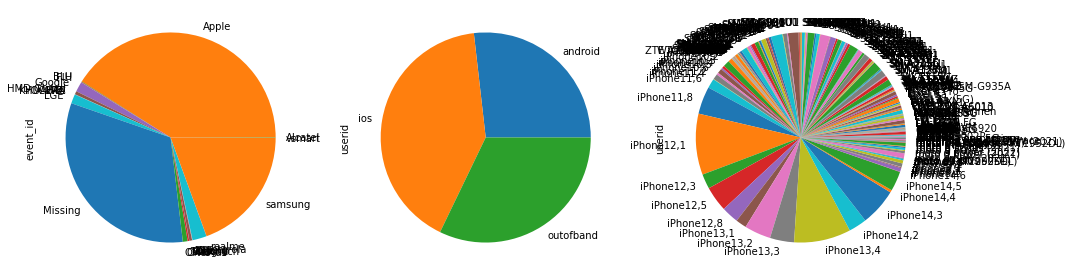

In [32]:
fig, axs = plt.subplots(1,3)
df.groupby('device_manufacture').count()['event_id'].plot(kind='pie',ax=axs[0])
df.groupby('event_platform').count()['userid'].plot(kind='pie',ax=axs[1])
df.groupby('device_model').count()['userid'].plot(kind='pie',ax=axs[2])

<b>Let us make a plot of successful added car manufacturers 

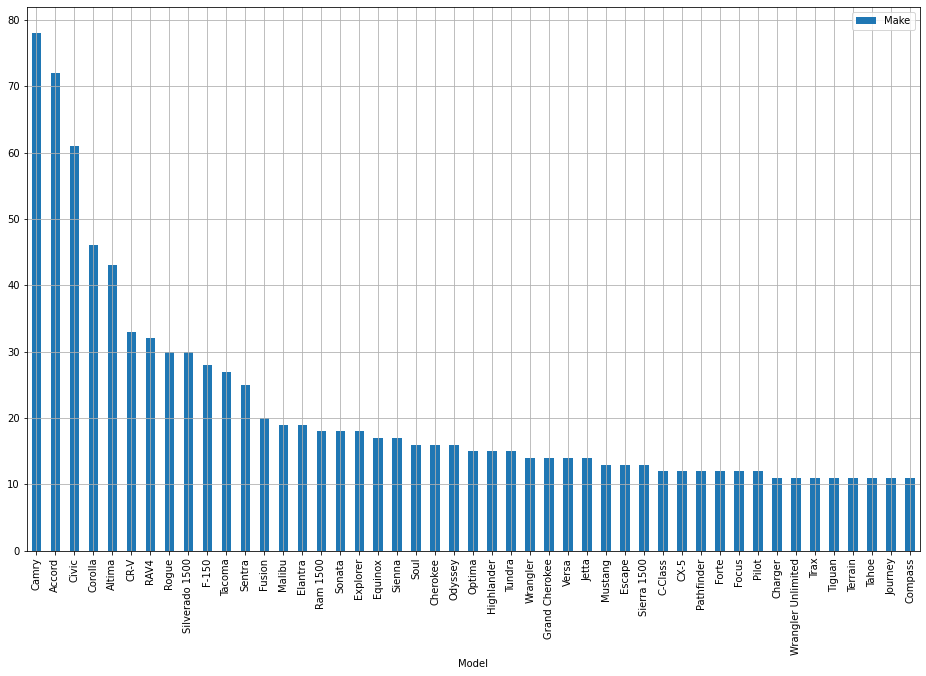

In [131]:
vehicles_count = pd.DataFrame(df_all[df_all["event_name"] == 'Add Vehicle Success']
            .groupby(["Model"])["Make"]
            .agg("count"))

def bar_with_limit(df: pd.DataFrame, limit: int) -> None:
    """"""
    df[df["Make"] > limit].plot.bar(grid=True)

bar_with_limit(vehicles_count.sort_values('Make',ascending=False), 10)

<b>Do users change the state?

In [33]:
any(df_all.groupby(['userid'])['user_state'].agg('unique').apply(len)!=1)

False

<b>Do users change the phone?

In [34]:
df_all.groupby(['userid'])['device_model'].agg('unique').apply(len).head(5)

userid
0006869712ec9841dc36234bce245203    2
000a59897372c5e3c147b15685fefc65    1
001244c572f1a681553bc045a378cacf    1
0032cb66b99f6baef57ec2aa04a9277f    1
003f57fe2631ade57a86f6a2b96bb20c    1
Name: device_model, dtype: int64

In [35]:
Counter(df_all.groupby(['userid'])['device_model'].agg('unique').apply(len))

Counter({2: 846, 1: 2669, 3: 24, 4: 1})

<b>Somebody changed the phone. Let`s check if it is not None

In [40]:
temp_ = (df_all[~pd.isna(df_all['device_model'])].groupby(['userid'])['device_model'].agg('unique').apply(len)!=1)

In [41]:
Counter(df_all[~pd.isna(df_all['device_model'])].groupby(['userid'])['device_model'].agg('unique').apply(len))

Counter({1: 3471, 0: 37, 2: 31, 3: 1})

In [42]:
people_who_changed_the_phone = np.array(temp_[temp_].keys())

There are people who renewed account

In [43]:
df_all[df_all['userid']==people_who_changed_the_phone[0]]

,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental state,Payment Method,Tokenized Pay,Method,Rental State,Error Code,Error Message,Id,Amount,Required,Renewal Date,Membership Type,From,Screen,Type,Navigated From,Status,Transaction type,Premium Membership,Description,Google Map Installed,Selected Route Type,Transaction Type,Promo code,event_created_date,event_name,userid,user_state,event_platform,device_manufacture,device_model,cancel
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3115,NaN,NaN,NaN,NaN,NaN,2022-02-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-05,Yearly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-04 01:03:36,Subscription Premium Renew,08a7303ab016a7c191c9de4f5620ca32,OH,outofband,NaN,NaN,0


In [44]:
temp_ = (df_all[~pd.isna(df_all['device_model'])].groupby(['userid'])['device_model'].agg('unique').apply(len)>1)

In [45]:
people_who_changed_the_phone = np.array(temp_[temp_].keys())

In [46]:
df_all[df_all['userid']==people_who_changed_the_phone[0]]

,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental state,Payment Method,Tokenized Pay,Method,Rental State,Error Code,Error Message,Id,Amount,Required,Renewal Date,Membership Type,From,Screen,Type,Navigated From,Status,Transaction type,Premium Membership,Description,Google Map Installed,Selected Route Type,Transaction Type,Promo code,event_created_date,event_name,userid,user_state,event_platform,device_manufacture,device_model,cancel
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4176,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Facebook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10 13:44:58,Sign Up Success,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-G988U1,0
4177,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10 13:46:53,Sign Out,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-G988U1,0
13847,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-15 11:18:00,Sign Out,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-S908U,0


In [47]:
#TCL and Motorola case
df_all[df_all['userid']==people_who_changed_the_phone[1]].head(5)

,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental state,Payment Method,Tokenized Pay,Method,Rental State,Error Code,Error Message,Id,Amount,Required,Renewal Date,Membership Type,From,Screen,Type,Navigated From,Status,Transaction type,Premium Membership,Description,Google Map Installed,Selected Route Type,Transaction Type,Promo code,event_created_date,event_name,userid,user_state,event_platform,device_manufacture,device_model,cancel
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4015,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-09 05:18:31,Sign Up Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0
4016,Chevrolet,Silverado 1500,Black,2001.0,false,NaT,NaT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-09 05:21:44,Add Vehicle Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0
9275,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,Debit,Google Pay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-27 21:45:30,Add Payment Method Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0
9276,NaN,NaN,NaN,NaN,NaN,2022-02-27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,Monthly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-27 21:46:31,Subscription Premium,107eea821b823c2218cc2f44fa7746d9,TX,outofband,NaN,NaN,0
9277,Dodge,Ram,White,2018.0,true,2022-02-27,2022-02-28,TX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-27 21:50:14,Add Vehicle Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0


<b>Let`s mark target_events

In [48]:
df_all['target'] = (df_all['event_name']=='Subscription Premium Cancel').astype(int)

Now let`s split by user

In [49]:
['userid', 'user_state', 'event_platform', 'device_manufacture', 'device_model', 'target','event_date']

['userid',
 'user_state',
 'event_platform',
 'device_manufacture',
 'device_model',
 'target',
 'event_date']

In [50]:
user_events = df_all.groupby('userid')['event_name'].apply(list)
user_target = df_all.groupby('userid')['target'].agg(sum)

<b> users with two cancellations

In [51]:
user_target[user_target==2],len(user_target[user_target==2])/len(user_target)

(userid
 078ae59f1ae79df514e846e5e51eca8b    2
 0c7170de11fabf2a805736938841cc8c    2
 1e78610bb127137ae210339776ac17d2    2
 2567193ff2ad4910e8b44dd1fc853195    2
 270c14cfefa4e0dc596c90f6a8c6c363    2
 375f680cd1242eb7bf9263dd5ba1fe6d    2
 3ba65939b03dd736b664863bd5e7eed4    2
 3d49da0965533c33153bb65eb1b6d11d    2
 5085db2422dd457f81d595b1adbfe4a8    2
 5393129fdf773191f7b3de51b35bb15d    2
 5a90e9973c256c19c17b03bdda1c1fc4    2
 73a754cf72593344bcd2412c1c24975b    2
 b288242d86302c56eb49562a7d73a5f2    2
 c0b5d24cf149f2eca81332ead49a4108    2
 c952231e6ea12e2bdd6f735453422008    2
 d263f69b765106b7790f098edb49f17b    2
 f510005f651751e9dd7fcf15fab240c3    2
 f57d02da24a18cd17a00aeddb46fa852    2
 fc817111904f14d8868601ac1e1fedeb    2
 fc9b74bab85fdc6cbdb5b965ca9f760f    2
 Name: target, dtype: int32,
 0.005649717514124294)

Bad events

In [52]:
[  'Subscription Premium Cancel''Add Payment Method Failed'  'Sign Out' 'Sign Up Error' 'Add Vehicle Failed'    'Reset Password Set']

['Subscription Premium CancelAdd Payment Method FailedSign OutSign Up ErrorAdd Vehicle FailedReset Password Set']

In [53]:
user_events = pd.DataFrame(user_events).join(user_target)

In [54]:
user_events.head(5)

,event_name,target
userid,,
0006869712ec9841dc36234bce245203,"[Add Payment Method Success, Subscription Prem...",0
000a59897372c5e3c147b15685fefc65,[Sign Up Success],0
001244c572f1a681553bc045a378cacf,[Sign Up Success],0
0032cb66b99f6baef57ec2aa04a9277f,[Sign Up Success],0
003f57fe2631ade57a86f6a2b96bb20c,"[Sign Up Success, Add Vehicle Success, Account...",0


In [55]:
plt.rcParams['figure.figsize'] = (16,10)

In [56]:
pd.set_option('display.max_columns', None)

In [57]:
temp_ = (df_all[~pd.isna(df_all['device_model'])].groupby(['userid'])['device_model'].agg('unique').apply(len)>1)

In [58]:
people_who_changed_the_phone = np.array(temp_[temp_].keys())

In [59]:
df_all[df_all['userid']==people_who_changed_the_phone[0]]

,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental state,Payment Method,Tokenized Pay,Method,Rental State,Error Code,Error Message,Id,Amount,Required,Renewal Date,Membership Type,From,Screen,Type,Navigated From,Status,Transaction type,Premium Membership,Description,Google Map Installed,Selected Route Type,Transaction Type,Promo code,event_created_date,event_name,userid,user_state,event_platform,device_manufacture,device_model,cancel,target
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4176,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Facebook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10 13:44:58,Sign Up Success,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-G988U1,0,0
4177,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10 13:46:53,Sign Out,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-G988U1,0,0
13847,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-15 11:18:00,Sign Out,0d89a51b9212a5e4f200d8bd6281b69b,PA,android,samsung,SM-S908U,0,0


In [60]:
#TCL and Motorola case
df_all[df_all['userid']==people_who_changed_the_phone[1]].head(3)

,Make,Model,Color,Year,Temporary,Start Date,End Date,Rental state,Payment Method,Tokenized Pay,Method,Rental State,Error Code,Error Message,Id,Amount,Required,Renewal Date,Membership Type,From,Screen,Type,Navigated From,Status,Transaction type,Premium Membership,Description,Google Map Installed,Selected Route Type,Transaction Type,Promo code,event_created_date,event_name,userid,user_state,event_platform,device_manufacture,device_model,cancel,target
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4015,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-09 05:18:31,Sign Up Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0,0
4016,Chevrolet,Silverado 1500,Black,2001.0,false,NaT,NaT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-09 05:21:44,Add Vehicle Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0,0
9275,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,Debit,Google Pay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-27 21:45:30,Add Payment Method Success,107eea821b823c2218cc2f44fa7746d9,TX,android,TCL,T766S,0,0


Let`s mark target_events

In [61]:
df_all['target'] = (df_all['event_name']=='Subscription Premium Cancel').astype(int)

# Event Markov chain

Let us assume that we have a following chain:

- Each event is a state 
- each transition is a change from one event to another

That means that our sequences of events for each user have a Markovian propery - memoryless model. It may be a simplfication,
but we obtain some interesting hypotheses from other data

In [76]:
target_by_user = df_all.groupby('userid')['target'].sum()
events_by_user = df_all.groupby('userid')['event_name'].apply(list)

In [77]:
events_names = list(df_all['event_name'].unique())
number_of_unique_events = len(events_names)

In [78]:
sequences = list(events_by_user.values)
events_map = {event_name:i for i,event_name in enumerate(events_names)}
matrix_of_events = np.zeros((number_of_unique_events,number_of_unique_events))
reverse_matrix_of_events = np.zeros((number_of_unique_events,number_of_unique_events))

In [82]:
for sequence in sequences:
    for i in range(0,len(sequence)-1):
        previous_event_id = events_map[sequence[i]]
        next_event_id = events_map[sequence[i+1]]
        matrix_of_events[previous_event_id][next_event_id]+=1
        reverse_matrix_of_events[next_event_id][previous_event_id]+=1
transition_matrix = (matrix_of_events.T/matrix_of_events.sum(axis=1)).T
reverse_transition_matrix = (reverse_matrix_of_events.T/reverse_matrix_of_events.sum(axis=1)).T

In [97]:
transition_df = pd.DataFrame(transition_matrix)
transition_df.index = events_names
transition_df.columns = events_names

reverse_transition_df = pd.DataFrame(reverse_transition_matrix)
reverse_transition_df.index = events_names
reverse_transition_df.columns = events_names

<b> Firstly, let's look at direct transition matrix (rows are normalized). We can clearly see that some events lead to other`s with significantly higher probability, such as:

    - 'add payment success' leads to 'subscription premium'
    - 'chat conversation opened' leads to 'chat conversation opened' and 'chat conversation started'
    - 'subscription premium' leads to 'transaction refund' and 'chat conversation opened'

<AxesSubplot:>

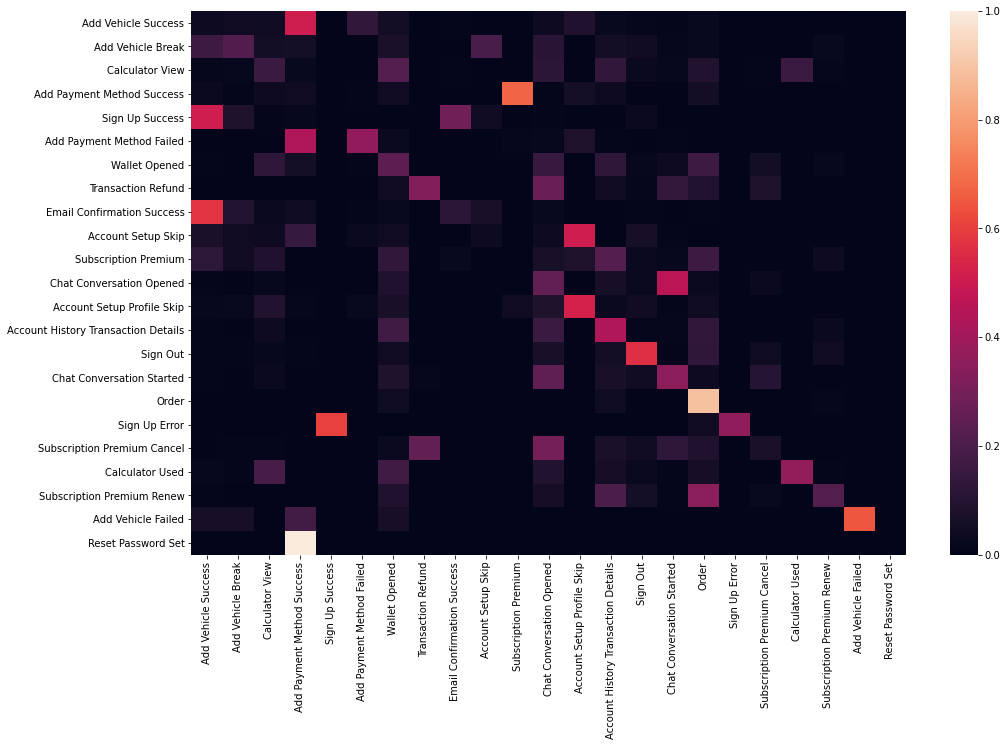

In [85]:
sns.heatmap(transition_matrix,xticklabels=events_names,yticklabels=events_names)

<b>We are particularly interested in cancellation event, so let's show the sorted transition's from other events

In [93]:
pd.DataFrame(transition_df.T['Subscription Premium Cancel'].sort_values(ascending=False))\
.style.background_gradient()

,Subscription Premium Cancel
Chat Conversation Opened,0.297561
Transaction Refund,0.253659
Chat Conversation Started,0.121951
Order,0.082927
Subscription Premium Cancel,0.068293
Account History Transaction Details,0.068293
Sign Out,0.043902
Wallet Opened,0.029268
Add Vehicle Break,0.009756
Calculator View,0.009756


<b> Now let`s look at reverse transition matrix. The main ideas was to learn markov chain on reverse sequences. It may show causation by previous event

<AxesSubplot:>

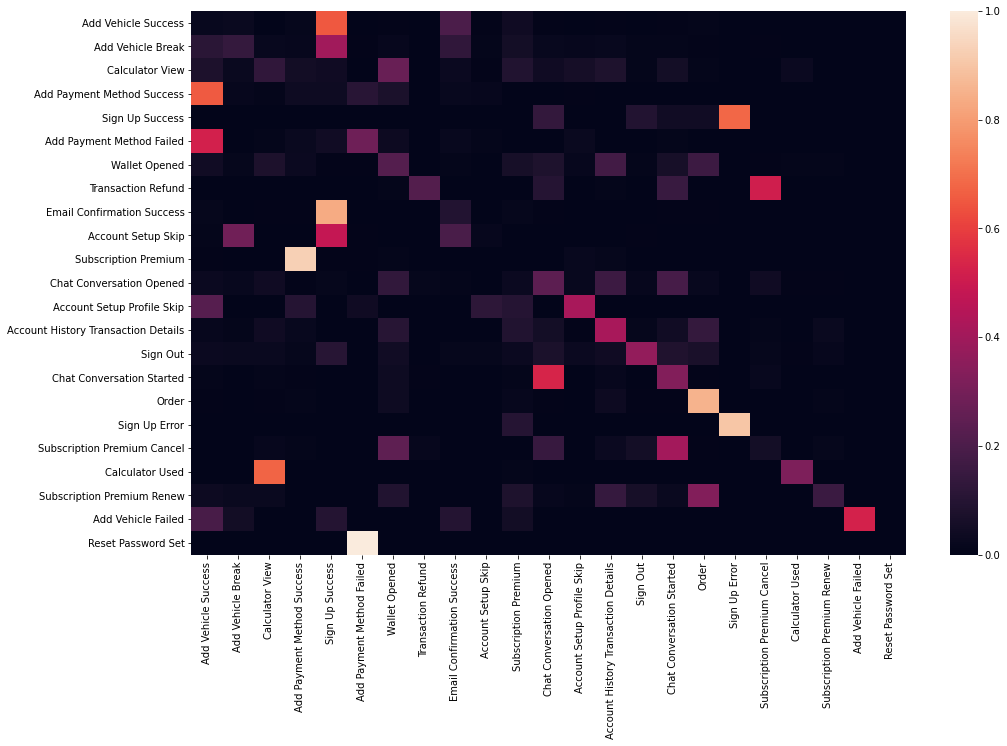

In [94]:
sns.heatmap(reverse_transition_matrix,xticklabels=events_names,yticklabels=events_names)

<b>The same sorted cancellation event probabilities, but as it was started from 'Cancel' event (posterior to prior)

In [103]:
pd.DataFrame(reverse_transition_df.T['Subscription Premium Cancel'].sort_values(ascending=False))\
    .style.background_gradient()

,Subscription Premium Cancel
Chat Conversation Started,0.405904
Wallet Opened,0.243542
Chat Conversation Opened,0.147601
Sign Out,0.051661
Subscription Premium Cancel,0.051661
Account History Transaction Details,0.029520
Calculator View,0.018450
Transaction Refund,0.018450
Subscription Premium Renew,0.014760
Add Payment Method Success,0.011070


<b> As we assumed, the martix above was build only on assumption of the condition from the previous event. However, there may be triplets of events, or even sequences, that lead to cancellation. That is why we can try to make a tree of events, that was built from sequences of events

In [104]:
class Node:
    def __init__(self,name):
        self.name=name
        self.counter = 0
        self.target = 0
        self.children = {}
        self.parent = None
    def add_child(self,child_name):
        if child_name not in self.children.keys():
            self.children[child_name] = Node(child_name)
        self.children[child_name].counter+=1
        self.counter+=1
        self.children[child_name].parent = self 
        return self.children[child_name]
    def __str__(self):
        return f"Name: {self.name}; Counter:{self.counter}"
    def get_children(self):
        return self.children
    def __getitem__(self,child_name):
        return self.children[child_name]
    def get_stat(self,depth,pprint=False):
        if depth==1:
            ratio = self.counter/self.parent.counter
            if pprint:
                return f'Counter={self.counter} Ratio={ratio}'
            return (self.counter,ratio)
        overall_stat = {}
        for child_name,child in self.children.items():
            overall_stat[child_name] = child.get_stat(depth-1,pprint)
        return overall_stat

In [106]:
def create_tree(sequences):
    tree = Node('root')
    for sequence in tqdm(sequences):
        node = tree
        # reverse sequence to see reverse causation 
        for event in sequence[::-1]+['START_END']:
            node = node.add_child(event)
    return tree

In [107]:
tree = create_tree(sequences)

100%|███████████████████████████████████████████████████████████████████████████| 3540/3540 [00:00<00:00, 55311.98it/s]


In [113]:
def pprint_tree(d, indent=0):
    for key, value in d.items():
        print('-' * indent + str(key))
        if isinstance(value, dict):
            pprint_tree(value, indent + 4)
        else:
            print('-' * (indent + 4) + str(value))

In [115]:
pprint_tree({'Subscription Premium Cancel':tree['Subscription Premium Cancel'].get_stat(3,pprint=True)})

Subscription Premium Cancel
----Chat Conversation Started
--------Chat Conversation Opened
------------Counter=35 Ratio=0.7
--------Chat Conversation Started
------------Counter=4 Ratio=0.08
--------Wallet Opened
------------Counter=1 Ratio=0.02
--------Subscription Premium
------------Counter=4 Ratio=0.08
--------Subscription Premium Renew
------------Counter=2 Ratio=0.04
--------Add Vehicle Success
------------Counter=2 Ratio=0.04
----Wallet Opened
--------Calculator View
------------Counter=2 Ratio=0.058823529411764705
--------Account History Transaction Details
------------Counter=12 Ratio=0.35294117647058826
--------Subscription Premium Renew
------------Counter=4 Ratio=0.11764705882352941
--------Wallet Opened
------------Counter=6 Ratio=0.17647058823529413
--------Chat Conversation Started
------------Counter=4 Ratio=0.11764705882352941
--------Order
------------Counter=2 Ratio=0.058823529411764705
--------Add Vehicle Break
------------Counter=2 Ratio=0.058823529411764705
------

This is a special tree structure, that shows how many users went to cancellation from other events. For example, from the last row - there were two sequences (two user paths) from 'sign out' to the 'order'.

Also, another example:  

----Sign Out

--------Chat Conversation Opened

------------Counter=4 Ratio=0.5

--------Chat Conversation Started

------------Counter=4 Ratio=0.5

4 users came from event-state 'Chat Conversation Started' to 'Sign Out' and  4 users came from event-state Chat Conversation Opened' to 'Sign Out'. And, as a result, as a sum,  8 users from exactly this 'Sign Out' to 'Cancellation'. 

This way, we could check the grouped order that led to cancellation (or any other interesting for us event)   

We can see that the number of 'Chat Conversation Opened' and 'Chat Conversation Started' significantly increases before subscription cancelation. The number of orders is 2-2.5 times lower before the cancelation than on a regular basis. Random forest attains 0.72 cross val F1-score. Some portion of the vectors is distinguishable in the 2-d pacmap representation.

TypeError: __init__() got an unexpected keyword argument 'n_components'

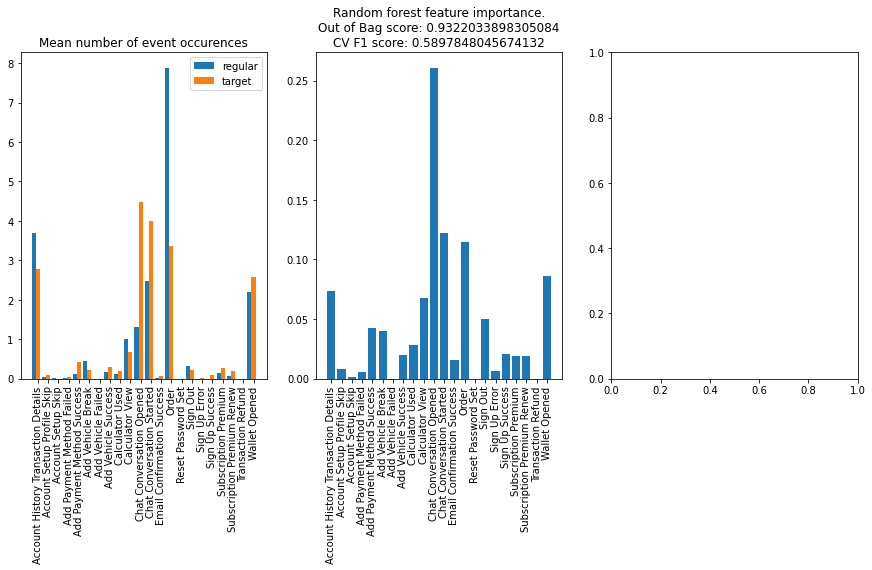

In [146]:
def get_vectors_by_number_of_events(df, n):
    users = np.unique(df[df['target'] == 1]['userid'])
    
    target_event_vectors = []
    regular_event_vectors = []

    for user in users:
        user_events = df_all[df_all['userid'] == user]
        n_user_events = len(user_events)
        if n_user_events < n:
            continue

        t = user_events
        cancelation_ind = np.where(user_events['target'] == 1)[0][0]
        start_ind = cancelation_ind - n

        if start_ind < 0:
            continue

        user_events_interval = user_events.iloc[start_ind:cancelation_ind]
        target_event_vector = np.zeros(n_event_names)
        for event in user_events_interval['event_name'].values:
            if event != 'Subscription Premium Cancel':
                target_event_vector[mapping[event]] += 1
        target_event_vectors.append(target_event_vector)

        end_ind = start_ind - 1
        start_ind = end_ind - n
        while start_ind > 0:
            user_events_interval = user_events.iloc[start_ind:end_ind]
            regular_event_vector = np.zeros(n_event_names)
            for event in user_events_interval['event_name'].values:
                if event != 'Subscription Premium Cancel':
                    regular_event_vector[mapping[event]] += 1
            regular_event_vectors.append(regular_event_vector)

            start_ind = start_ind - 1
            end_ind = end_ind - 1

    return regular_event_vectors, target_event_vectors


event_names = ['Account History Transaction Details', 'Account Setup Profile Skip', 'Account Setup Skip', 
               'Add Payment Method Failed', 'Add Payment Method Success',  'Add Vehicle Break', 'Add Vehicle Failed',
               'Add Vehicle Success', 'Calculator Used', 'Calculator View', 'Chat Conversation Opened',
               'Chat Conversation Started', 'Email Confirmation Success', 'Order', 'Reset Password Set', 'Sign Out',
               'Sign Up Error', 'Sign Up Success', 'Subscription Premium', 'Subscription Premium Renew',
               'Transaction Refund','Wallet Opened']

n_event_names = len(event_names)
mapping = dict(zip(sorted(event_names), np.arange(n_event_names)))

for i, n in enumerate((20, 25, 30)):
    regular_event_vectors, target_event_vectors = get_vectors_by_number_of_events(df_all, n)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    regular_event_vectors_mean = np.array(regular_event_vectors).mean(axis=0)
    target_event_vectors_mean = np.array(target_event_vectors).mean(axis=0)
    axes[0].bar(np.arange(len(event_names)) - 0.2, regular_event_vectors_mean, tick_label=event_names, width=0.4, label='regular')
    axes[0].bar(np.arange(len(event_names)) + 0.2, target_event_vectors_mean, tick_label=event_names, width=0.4, label='target')
    axes[0].legend()
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
    axes[0].set_title('Mean number of event occurences')

    combined = np.array(target_event_vectors + regular_event_vectors)
    labels = np.concatenate((np.ones(len(target_event_vectors)), np.zeros(len(regular_event_vectors))))
    forest = RandomForestClassifier(oob_score=True)
    forest.fit(combined, labels)
    cv_score = np.mean(cross_val_score(forest, combined, labels, cv=5, scoring='f1'))
    axes[1].bar(np.arange(len(event_names)), forest.feature_importances_, tick_label=event_names)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
    axes[1].set_title(f'Random forest feature importance.\nOut of Bag score: {forest.oob_score_}\nCV F1 score: {cv_score}')

    scaler = StandardScaler()
    combined_s = scaler.fit_transform(combined)
    colors = ['yellow' if i else 'blue' for i in labels]
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
    transformed_pacmap = embedding.fit_transform(combined_s, init="pca")
    axes[2].scatter(transformed_pacmap[:, 0], transformed_pacmap[:, 1], c=colors)
    axes[2].set_title('PACMAP 2-d representation')
    
    plt.suptitle(f'{n} events interval')
    plt.tight_layout()
    plt.show()

We can see a similar picture, where the number of 'Chat Conversation Opened' and 'Chat Conversation Started' gets larger before the cancelation. The number of orders is once again 1.5-2 times smaller depencing the interval size. Random forest classifier achieves 0.9 F1-score on the 30 event intervals. 30-events intervals are also clustered in the 2-d pacmap representation. 

In [145]:
pip  install -U pacmap

  Attempting uninstall: pacmap
    Found existing installation: pacmap 0.5.3
    Uninstalling pacmap-0.5.3:
      Successfully uninstalled pacmap-0.5.3
Note: you may need to restart the kernel to use updated packages.


# Conclusion

During the execution of the test task, our team have made an EDA  and considered 2 approaches to the execution of the task: static with respect to the user and dynamic due to the sequence of events.
In the static approach, the main idea was to move from the essence of events with their properties to the essence of users with their properties, and already determine which properties of the user make him most prone to cancel premium. In dynamic, we considered the sequence of events that could lead to subscription cancelling. Due to outliers (20 users cancelled  without having a subscription event) and a small sample of data (only about 200 users cancelled subscription in total out of 3500), it was decided to develop a dynamic approach. This approach included:
- built the Markov chain and its transition matrix  
- create event tree
